In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [42]:
data_train =pd.read_csv('./data_train_more_knn_append.csv') 
data_test= pd.read_csv('./data_test_more_knn_append.csv') 
data_test.head(5)


Unnamed: 0      entid  ANCHEYEAR_ar  EMPNUM_ar  WOMEMPNUM     BUSST  \
0           0  952000000       2015.89    14.5842    8.15746  13.73750   
1           1  422000000       2016.00     7.6000    5.66667  13.00000   
2           2  475000000       2015.50    10.6667   13.00000   5.00000   
3           3  487000000       2015.89    14.5842    8.15746  13.73750   
4           4  510000000       2015.50    85.3333   76.66670   3.66667   

   ANCHEYEAR_asserts  ispublic_asserts      ASSGRO      LIAGRO  ...  \
0            2016.25                 1     6.43528   -0.344703  ...   
1            2015.75                 1     2.79050   -0.516151  ...   
2            2014.50                 1  2680.36000  518.716000  ...   
3            2015.18                 1    60.40020   -0.112609  ...   
4            2015.84                 1    63.00840   60.476800  ...   

   incometax_amount  incometax_actual  lixibeishu           ROE  \
0           154.377      2.863890e+05    4.369908  60118.609990   
1          2174.670     -1.899070e-01    1.403182      0.025135   
2       1070000.000      1.060000e+06   81.476592   1600.658768   
3           154.377      2.864380e+05    4.370146   7354.644429   
4           157.108      2.863890e+05    4.369908  20699.104090   

   Gross_profit_margin  Net_profit_margin   operating_cashflow  biandong   \
0             9.875000            0.042333        9.031017e+06   -19.4866   
1        575407.526000            0.252358        1.218712e+00    16.3817   
2             3.000000            0.652830        5.237961e+06    12.3044   
3             9.750000            0.042333        9.031022e+06   -56.9625   
4             9.895833            0.042333        9.025994e+06   -23.5279   

      shourubili          daiyu  
0       0.186458      72.087677  
1  153690.598100  394923.037600  
2       0.010784       0.295040  
3       0.185417      71.349732  
4       0.185417      72.087680  

[5 rows x 119 columns]

In [43]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))


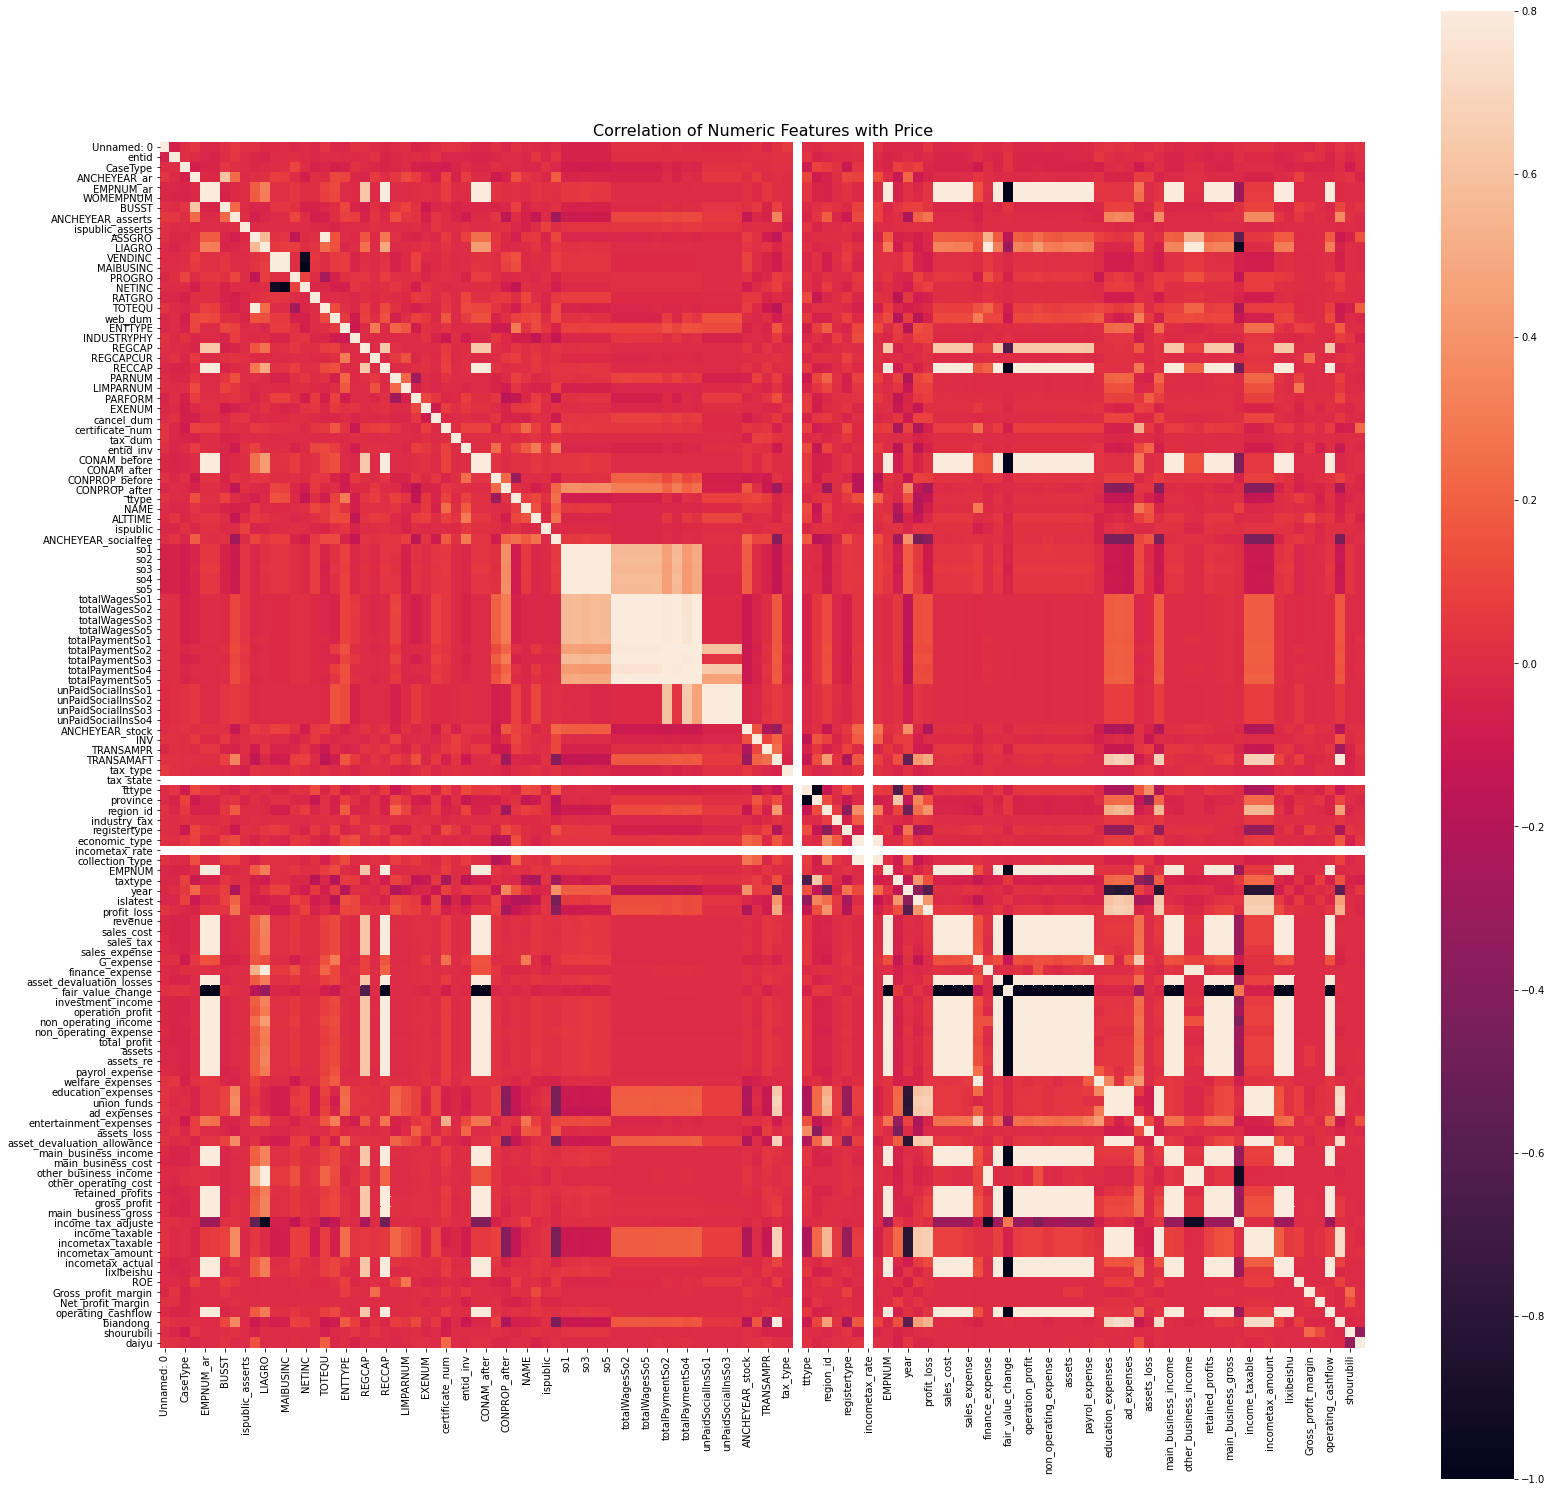

In [44]:
# 皮尔森相关系数
x_train = data_train.drop(['entid','CaseType'], axis=1)
#计算协方差
# data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
# result = pd.DataFrame(columns=['features', 'corr'])
# result['features'] = data_corr.index
# result['corr'] = data_corr.values

# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (27, 27))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)
plt.savefig('./cor.png')

In [45]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# 读取数据

X_train =pd.read_csv('data_train_more_knn_append.csv').drop(['entid', 'CaseType','Unnamed: 0', "Unnamed: 0.1"] , axis=1)
X_test = pd.read_csv('data_test_more_knn_append.csv').drop(['entid',"Unnamed: 0"],  axis=1)
y_train = pd.read_csv('data_train_more_knn_append.csv').loc[:, 'CaseType']

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)
X_train.info()


KeyError: "['Unnamed: 0.1'] not found in axis"

In [ ]:
from sklearn.model_selection import KFold
# 分离数据集，方便进行交叉验证
# X_train = data.loc[data['sample']=='train', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
# X_test = data.loc[data['sample']=='test', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
# y_train = data.loc[data['sample']=='train', 'isDefault']
# y_train = X_train.loc[:, 'CaseType']


# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [ ]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective':'multiclass',
            'num_class':4,
            'learning_rate': 0.01,
            'metric': 'multi_logloss',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=2000)


LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
#fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)

val_pre_lgb = np.argmax(val_pre_lgb,axis=1)
print(val_pre_lgb.shape)
roc_auc = classification_report(y_val, val_pre_lgb)



(417,)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report


"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class':4,
                'learning_rate': 0.1,
                'metric': 'multi_logloss',
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }

 
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred = np.argmax(val_pred,axis=1)
    print(classification_report(y_val, val_pred))
    #cv_scores.append()
    #print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
# print("lgb_score_mean:{}".format(np.mean(cv_scores)))
# print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.200804
              precision    recall  f1-score   support

           0       0.60      0.25      0.35        12
           1       0.33      0.12      0.18         8
           2       0.91      0.62      0.74        16
           3       0.95      0.99      0.97       381

    accuracy                           0.94       417
   macro avg       0.70      0.50      0.56       417
weighted avg       0.93      0.94      0.93       417

************************************ 2 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.185841
              precision    recall  f1-score   s

In [ ]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective= 'multiclass', num_class=4, metric='multi_logloss',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, X_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    
    return val


In [ ]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.54, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54
[LightGBM] [Warning] bagging_fraction is set=0.59, subsample=1.0 will be ignored. Current value: bagging_fraction=0.59
[LightGBM] [Warning] bagging_freq is set=96, subsample_freq=0 will be ignored. Current value: bagging_freq=96
|  1        |  nan      |  0.5878   |  96.71    |  0.5386   |  18.12    |  5.517    |  52.65    |  0.1235   |  19.66    |  8.986    |  4.755    |
|  2        |  nan      |  0.8691   |  30.01    |  0.9884   |  10.84    |  9.475    |

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
"""显示优化结果"""
bayes_lgb.max


In [ ]:
"""调整一个较小的学习率，并通过cv函数确定当前最优的迭代次数"""
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
                    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    train_set=train_matrix,
    early_stopping_rounds=1000, 
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    params=base_params_lgb,
    metrics='auc',
    seed=0
)

print('迭代次数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))


In [ ]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 14,
                'max_depth': 19,
                'min_data_in_leaf': 37,
                'min_child_weight':1.6,
                'bagging_fraction': 0.98,
                'feature_fraction': 0.69,
                'bagging_freq': 96,
                'reg_lambda': 9,
                'reg_alpha': 7,
                'min_split_gain': 0.4,
                'nthread': 8,
                'seed': 2020,
                'silent': True,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=14269, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))
